<a href="https://colab.research.google.com/github/so-yeon-hwang/DataSciencePractice/blob/main/Auto_Encoder_MNIST_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 01 Data Loading

In [2]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.utils as utios
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm import tqdm

print("Python : ", sys.version)
print("Numpy : ", np.__version__)
print("Torch : ", torch.__version__)
print("Torchvision : ", torchvision.__version__)

Python :  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Numpy :  1.25.2
Torch :  2.2.1+cu121
Torchvision :  0.17.1+cu121


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # cuda 지원 GPU 없음

cpu


In [5]:
# 변수할당

batch_size = 100
learning_rate = 0.001
num_epochs = 10

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

download_root = './MNIST_DATASET'

In [8]:
# mnist_transform 변환 파이프라인의 역할

# (1) 형태변환 PIL (Python Imaging Library) → 파이토치 tensor
# (2) 픽셀 값 범위 정규화 : [0,255] → [0.0, 1.0]
# (3) 채널 순서 변경 PIL image (H x W x C) → torch tensor (C x H x W)

# 변환 파이프라인 구축
mnist_transform = transforms.Compose([ # transforms.Compose() 함수는 원래 여러 함수를 하나로 묶는 역할(인데 여기선 하나의 함수)
    transforms.ToTensor(),
])


train_dataset = MNIST(download_root,
                      transform = mnist_transform, # 변환 파이프라인 적용
                      train = True,
                      download = True)

test_dataset = MNIST(download_root,
                     transform = mnist_transform,
                     train = False, # → testset
                     download = False) # 위에서 다운로드 받아서 불필요

100%|██████████| 9912422/9912422 [00:00<00:00, 110129958.40it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 59148288.00it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31601490.52it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11121149.31it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



In [10]:
# 데이터셋 확인
def print_MNIST_dataset_info(dataset):
  print("dataset length : ", len(dataset))
  print("type of each data : ", type(dataset[0]))
  first_img, first_label = dataset[0]
  print("image shape : ", first_img.shape)
  print("image dtype : ", first_img.dtype)
  print("image pixel min-value : ", first_img.min())
  print("label data type : ", type(first_label))

print("<Train Dataset Info>")
print_MNIST_dataset_info(train_dataset)
print()

print("<Test Dataset Info>")
print_MNIST_dataset_info(test_dataset)


<Train Dataset Info>
dataset length :  60000
type of each data :  <class 'tuple'>
image shape :  torch.Size([1, 28, 28])
image dtype :  torch.float32
image pixel min-value :  tensor(0.)
label data type :  <class 'int'>

<Test Dataset Info>
dataset length :  10000
type of each data :  <class 'tuple'>
image shape :  torch.Size([1, 28, 28])
image dtype :  torch.float32
image pixel min-value :  tensor(0.)
label data type :  <class 'int'>


In [13]:
# DataLoader 정의
# DataLoader : 데이터셋을 미니배치로 나누어주는 utility into batch_size

from torch.utils.data import DataLoader

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle = True)

test_loader = DataLoader(dataset = test_dataset,
                         batch_size = batch_size,
                         shuffle = False)

In [15]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# 첫 번째 이미지 찍어보기
batch_images, batch_labels = next(iter(train_loader))

In [16]:
batch_labels

tensor([3, 9, 3, 9, 6, 6, 5, 4, 4, 7, 1, 3, 0, 7, 8, 4, 0, 5, 6, 0, 3, 9, 3, 0,
        1, 9, 4, 7, 1, 0, 1, 3, 5, 5, 5, 5, 1, 0, 0, 0, 5, 8, 8, 0, 9, 5, 2, 3,
        1, 8, 9, 3, 8, 3, 8, 0, 7, 3, 4, 7, 6, 1, 9, 4, 3, 2, 4, 8, 5, 4, 0, 0,
        4, 1, 4, 4, 7, 2, 4, 1, 4, 8, 4, 6, 5, 9, 3, 5, 4, 1, 0, 3, 7, 4, 0, 7,
        2, 6, 9, 2])

first image label :  3


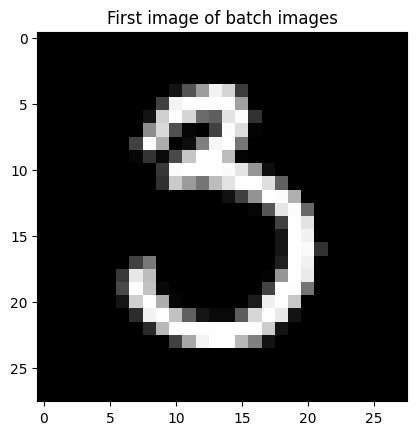

In [23]:
img = batch_images[0]

# batch_images 뭉텅이의 첫 번째 이미지는 어떤 숫자를 그린 것인가? label 확인해보기
print("first image label : ", int(batch_labels[0]))

# batch_images 뭉텅이에서 첫 번째 이미지 찍어보기
plt.figure()
plt.imshow(to_pil_image(img), cmap = 'gray')
plt.title("First image of batch images")
plt.show()


## 02 AE Model

In [83]:
n_dim = 2
# 인코더의 출력차원은 2 (잠재공간의 차원)
# latent space dimension == 2

# 인코더 정의

# nn.Sequential : 파이토치에서 모듈을 순차적으로 쌓아 신경망을 정의
enc = nn.Sequential(
    nn.Flatten(), # MNIST 28x28 이미지 → 784차원 벡터로 변환
    nn.Linear(784, 256),
    nn.ReLU(), # 비선형 함수(non-linear)로 enhance complexity, 양수는 그대로, 음수는 0으로
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Linear(32,n_dim)
)

enc = enc.to(device)

print("Encoder : ")
print(enc)
print()

# 디코더 정의
dec = nn.Sequential(
    nn.Linear(n_dim,32),
    nn.ReLU(),
    nn.Linear(32,256),
    nn.ReLU(),
    nn.Linear(256,784),
    nn.Unflatten(1, torch.Size([1,28,28])),
    nn.Sigmoid()
)

dec = dec.to(device)
print("Decoder : ")
print(dec)
print()

# auto encoder 정의

ae = nn.Sequential(
    enc,
    dec,
)

ae = ae.to(device)
print("Auto Encoder : ")
print(ae)

Encoder : 
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=32, bias=True)
  (6): ReLU()
  (7): Linear(in_features=32, out_features=2, bias=True)
)

Decoder : 
Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Unflatten(dim=1, unflattened_size=torch.Size([1, 28, 28]))
  (6): Sigmoid()
)

Auto Encoder : 
Sequential(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_fe

### 파라미터 초기화 - w/ Xavier

In [84]:
# 기존 파라미터
print(list(ae.parameters()))

[Parameter containing:
tensor([[-0.0176, -0.0200, -0.0242,  ..., -0.0329,  0.0272,  0.0204],
        [ 0.0237, -0.0276, -0.0292,  ..., -0.0123, -0.0087, -0.0006],
        [-0.0294,  0.0223, -0.0324,  ...,  0.0188, -0.0054, -0.0344],
        ...,
        [ 0.0322,  0.0027,  0.0279,  ...,  0.0294,  0.0167, -0.0028],
        [ 0.0335,  0.0276, -0.0155,  ..., -0.0332, -0.0182,  0.0075],
        [ 0.0201,  0.0142, -0.0182,  ...,  0.0007,  0.0323, -0.0242]],
       requires_grad=True), Parameter containing:
tensor([-2.5878e-02, -3.2660e-02,  2.5316e-02,  1.4552e-02, -2.9281e-02,
         2.8566e-02,  2.9510e-02, -3.4728e-02,  5.1981e-03, -3.2080e-02,
        -1.8737e-02,  1.0291e-02, -6.2345e-03, -1.6782e-02, -1.6495e-03,
         3.2270e-02, -3.5547e-03, -1.5667e-02,  1.0231e-02, -2.9358e-02,
        -4.3870e-03, -7.0574e-04,  1.1391e-02, -1.2976e-02, -1.6040e-02,
         2.2966e-03, -4.5251e-03,  2.8487e-02, -3.0716e-02, -8.8371e-03,
        -1.6980e-02,  1.6166e-02,  2.3532e-02, -3.2171e

In [85]:
## TODO
# 정규분포를 따르는 weight 초기화
def init_weights(m):
  for l in m.modules():
    if isinstance(l, nn.Linear):
      nn.init.xavier_uniform(l.weight)

ae.apply(init_weights)

## 파라미터 초기화 이후
print(list(ae.parameters()))

[Parameter containing:
tensor([[-0.0627,  0.0642,  0.0048,  ..., -0.0243,  0.0099,  0.0264],
        [ 0.0621,  0.0028,  0.0405,  ..., -0.0238,  0.0428,  0.0395],
        [-0.0280,  0.0523, -0.0635,  ...,  0.0698,  0.0261, -0.0532],
        ...,
        [-0.0197,  0.0082, -0.0362,  ...,  0.0311,  0.0554, -0.0285],
        [ 0.0478,  0.0694, -0.0054,  ...,  0.0263,  0.0420, -0.0105],
        [-0.0254,  0.0103,  0.0266,  ..., -0.0022,  0.0341,  0.0124]],
       requires_grad=True), Parameter containing:
tensor([-2.5878e-02, -3.2660e-02,  2.5316e-02,  1.4552e-02, -2.9281e-02,
         2.8566e-02,  2.9510e-02, -3.4728e-02,  5.1981e-03, -3.2080e-02,
        -1.8737e-02,  1.0291e-02, -6.2345e-03, -1.6782e-02, -1.6495e-03,
         3.2270e-02, -3.5547e-03, -1.5667e-02,  1.0231e-02, -2.9358e-02,
        -4.3870e-03, -7.0574e-04,  1.1391e-02, -1.2976e-02, -1.6040e-02,
         2.2966e-03, -4.5251e-03,  2.8487e-02, -3.0716e-02, -8.8371e-03,
        -1.6980e-02,  1.6166e-02,  2.3532e-02, -3.2171e

<ipython-input-85-c6d2a18b5a2e>:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(l.weight)


## 네트워크 모델 구조 확인

In [45]:
! pip install torchsummary

In [46]:
from torchsummary import summary
summary(ae, (1,28,28)) # summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 32]           4,128
              ReLU-7                   [-1, 32]               0
            Linear-8                    [-1, 2]              66
            Linear-9                   [-1, 32]              96
             ReLU-10                   [-1, 32]               0
           Linear-11                  [-1, 256]           8,448
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 784]         201,488
        Unflatten-14            [-1, 1,

In [ ]:
# 유의
# ae 함수는 batch 단위로 수행됨 → ( batch, 1, 28, 28 )로 병렬처리

## 오토인코더 학습

In [86]:
optimizer = torch.optim.Adam(ae.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [87]:
# 학습 fit() 함수 구현

def fit(data_loader, epochs):
  for epoch in range(epochs):
    now = time.time()
    avg_loss = 0
    total_batch = len(data_loader)

    for i, (batch_images, batch_labels) in enumerate(data_loader):

      X = batch_images.to(device)  # [-1, 1, 28, 28]

      # forward 단계
      Y_prediction = ae(X)
      loss = criterion(Y_prediction, X)


      # bacward 단계
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_loss += loss / total_batch

    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
          .format(epoch + 1, avg_loss.data, time.time()-now))

  print("Learning Finished!")

In [ ]:
# 파라미터 업데이트 이전 최종 loss : 0.0372 / 0.0389

In [88]:
fit(train_loader, num_epochs)

[Epoch:    1] 	 loss = 0.0578 	 time = 20.2022
[Epoch:    2] 	 loss = 0.0456 	 time = 22.0818
[Epoch:    3] 	 loss = 0.0428 	 time = 21.0467
[Epoch:    4] 	 loss = 0.0413 	 time = 22.0653
[Epoch:    5] 	 loss = 0.0403 	 time = 21.8819
[Epoch:    6] 	 loss = 0.0396 	 time = 21.0622
[Epoch:    7] 	 loss = 0.0389 	 time = 21.6842
[Epoch:    8] 	 loss = 0.0383 	 time = 27.7978
[Epoch:    9] 	 loss = 0.0380 	 time = 20.1391
[Epoch:   10] 	 loss = 0.0378 	 time = 19.0456
Learning Finished!


train_dataset에 대한 결과 시각화

In [58]:
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def train_dataset_imshow(idx): # 해당 인덱스 하나에 대하여
  (image,label) = train_dataset[idx] # 해당 인덱스에 대한 이미지+라벨을 뽑아줌

  print("GT label : ", label)

  X = torch.unsqueeze(image,0).to(device)
  # x : 오토인코더에 들어가기 전의 real data
  # 이미지에 0번째에 차원 하나 추가(unsqueeze) | 이후 device 저장장치 | X 라는 변수에 할당


  Y_pred = ae(X) # 오토인코더에 X 넣기 -> x^ 만들어짐

  input_img = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())

  plt.subplot(121)
  plt.imshow(input_img, cmap = 'gray')

  plt.subplot(122)
  plt.imshow(output_img, cmap = 'gray')

  plt.show()

In [59]:
widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(train_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

<function __main__.train_dataset_imshow(idx)>

In [60]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def test_dataset_imshow(idx):
  (image, label) = test_dataset[idx]
  print('GT label:', label)

  X      = torch.unsqueeze(image, 0).to(device) # batch size = 1
  Y_pred = ae(X)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')

  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(test_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(test_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

<function __main__.test_dataset_imshow(idx)>

## 인코더 / 디코더 모델 따로 써보기

GT label :  8


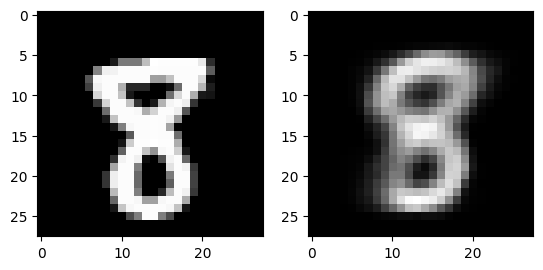

In [61]:
from torchvision.transforms.functional import to_pil_image

idx = 128

(image, label) = test_dataset[idx]
print("GT label : ", label)

X = torch.unsqueeze(image,0).to(device)
z = enc(X)  # latent space 잠재공간에 구현된 z
Y_pred = dec(z)

input_img = to_pil_image(X.squeeze())
output_img = to_pil_image(Y_pred.squeeze())

plt.subplot(121)
plt.imshow(input_img, cmap = 'gray')

plt.subplot(122)
plt.imshow(output_img, cmap = 'gray')

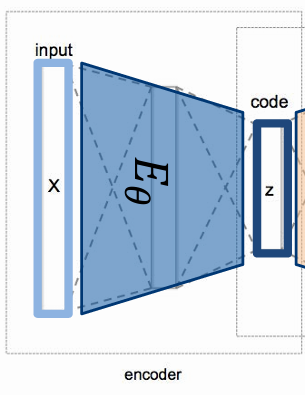

### n_dim = 2

In [63]:
# MNIST latent space 시각화 : z 분포 w/ color

whole_test_loader = DataLoader(dataset = test_dataset,
                               batch_size = len(test_dataset),
                               shuffle = False)

whole_test_images, whole_test_labels = next(iter(whole_test_loader))
whole_test_images = whole_test_images.to(device) # 저장소로 보내기
whole_test_labels = whole_test_labels.to(device)
# len(whole_test_labels) >>> 10,000


In [66]:
z = enc(whole_test_images)

In [67]:
z

tensor([[ 46.6410, -21.2210],
        [ -1.5148,   1.7788],
        [ 94.1793,  69.7842],
        ...,
        [ 22.8645,  -2.9869],
        [  6.3730,   7.2172],
        [ 11.9431, -34.9731]], grad_fn=<AddmmBackward0>)

In [68]:
# 라벨에 따른 슬라이싱
z_0 = z[whole_test_labels==0]
z_1 = z[whole_test_labels==1]
z_2 = z[whole_test_labels==2]
z_3 = z[whole_test_labels==3]
z_4 = z[whole_test_labels==4]
z_5 = z[whole_test_labels==5]
z_6 = z[whole_test_labels==6]
z_7 = z[whole_test_labels==7]
z_8 = z[whole_test_labels==8]
z_9 = z[whole_test_labels==9]

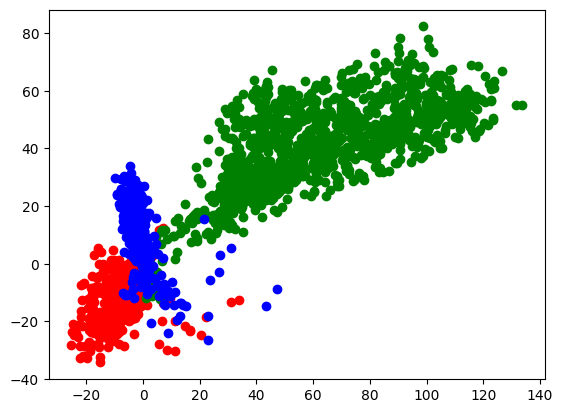

In [80]:
plt.plot(z_0[:,0].detach().cpu().numpy(), z_0[:,1].detach().cpu().numpy(), 'ro')
plt.plot(z_1[:,0].detach().cpu().numpy(), z_1[:,1].detach().cpu().numpy(), 'go')
plt.plot(z_2[:,0].detach().cpu().numpy(), z_2[:,1].detach().cpu().numpy(), 'bo')
#plt.plot(z_3[:,0].detach().cpu().numpy(), z_3[:,1].detach().cpu().numpy(), 'yo')

### n_dim = 32

In [ ]:
## with new dimension of z

In [89]:
n_dim = 32

enc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Linear(32,n_dim)
)

enc = enc.to(device)

# 디코더 정의
dec = nn.Sequential(
    nn.Linear(n_dim,32),
    nn.ReLU(),
    nn.Linear(32,256),
    nn.ReLU(),
    nn.Linear(256,784),
    nn.Unflatten(1, torch.Size([1,28,28])),
    nn.Sigmoid()
)

dec = dec.to(device)

# auto encoder 정의

ae = nn.Sequential(
    enc,
    dec,
)

ae = ae.to(device)


# ae 파라미터 초기화

def init_weights(m):
  for l in m.modules():
    if isinstance(l, nn.Linear):
      nn.init.xavier_uniform(l.weight)

ae.apply(init_weights)


# 오토인코더 학습

optimizer = torch.optim.Adam(ae.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

# 학습 fit() 함수 구현

def fit(data_loader, epochs):
  for epoch in range(epochs):
    now = time.time()
    avg_loss = 0
    total_batch = len(data_loader)

    for i, (batch_images, batch_labels) in enumerate(data_loader):

      X = batch_images.to(device)  # [-1, 1, 28, 28]

      # forward 단계
      Y_prediction = ae(X)
      loss = criterion(Y_prediction, X)


      # bacward 단계
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_loss += loss / total_batch

    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
          .format(epoch + 1, avg_loss.data, time.time()-now))

  print("Learning Finished!")

<ipython-input-89-f07b2baf8e21>:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(l.weight)


In [90]:
fit(train_loader, num_epochs)

[Epoch:    1] 	 loss = 0.0396 	 time = 22.9575
[Epoch:    2] 	 loss = 0.0197 	 time = 17.2424
[Epoch:    3] 	 loss = 0.0162 	 time = 18.0207
[Epoch:    4] 	 loss = 0.0144 	 time = 17.6803
[Epoch:    5] 	 loss = 0.0131 	 time = 17.4024
[Epoch:    6] 	 loss = 0.0121 	 time = 17.6225
[Epoch:    7] 	 loss = 0.0114 	 time = 17.1623
[Epoch:    8] 	 loss = 0.0109 	 time = 18.4271
[Epoch:    9] 	 loss = 0.0104 	 time = 17.7359
[Epoch:   10] 	 loss = 0.0100 	 time = 18.9980
Learning Finished!


#### TODOs

In [98]:
z = enc(whole_test_images)

In [102]:
z_0 = z[whole_test_labels==0]
z_1 = z[whole_test_labels==1]
z_2 = z[whole_test_labels==2]
z_3 = z[whole_test_labels==3]
z_4 = z[whole_test_labels==4]
z_5 = z[whole_test_labels==5]
z_6 = z[whole_test_labels==6]
z_7 = z[whole_test_labels==7]
z_8 = z[whole_test_labels==8]
z_9 = z[whole_test_labels==9]

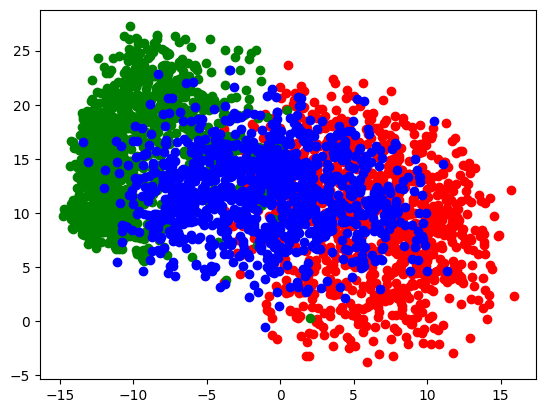

In [103]:
plt.plot(z_0[:,0].detach().cpu().numpy(), z_0[:,1].detach().cpu().numpy(), 'ro')
plt.plot(z_1[:,0].detach().cpu().numpy(), z_1[:,1].detach().cpu().numpy(), 'go')
plt.plot(z_2[:,0].detach().cpu().numpy(), z_2[:,1].detach().cpu().numpy(), 'bo')

In [101]:
z, z.shape

(tensor([[  1.9507,   6.9978, -21.8647,  ...,  -1.5278,  -3.5515,   3.3674],
         [ -5.8782,   9.2769, -11.1147,  ...,   6.2363, -16.9798,  -1.5134],
         [-11.1107,  15.4088, -20.3417,  ...,   1.5970, -11.6249,  -2.7215],
         ...,
         [ -6.7907,  19.1043, -14.2864,  ...,  -0.6341,  -8.3803,  -5.7079],
         [ -4.2369,  16.2274, -15.2309,  ...,   0.4180, -13.2680,   1.8435],
         [  6.1851,  13.9597,  -6.4564,  ...,  -0.8536, -23.7104,  -6.4898]],
        grad_fn=<AddmmBackward0>),
 torch.Size([10000, 32]))

In [96]:
# z 공간의 임의의 위치를 sampling

z = torch.randn(3, n_dim).to(device)
z = torch.FloatTensor(z).to(device)
result = dec(z)

print(z.shape)
print(result.shape)

torch.Size([3, 32])
torch.Size([3, 1, 28, 28])


### n_dim = 16

In [105]:
n_dim = 16

enc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Linear(32,n_dim)
)

enc = enc.to(device)

# 디코더 정의
dec = nn.Sequential(
    nn.Linear(n_dim,32),
    nn.ReLU(),
    nn.Linear(32,256),
    nn.ReLU(),
    nn.Linear(256,784),
    nn.Unflatten(1, torch.Size([1,28,28])),
    nn.Sigmoid()
)

dec = dec.to(device)

# auto encoder 정의

ae = nn.Sequential(
    enc,
    dec,
)

ae = ae.to(device)


# ae 파라미터 초기화

def init_weights(m):
  for l in m.modules():
    if isinstance(l, nn.Linear):
      nn.init.xavier_uniform(l.weight)

ae.apply(init_weights)


# 오토인코더 학습

optimizer = torch.optim.Adam(ae.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

# 학습 fit() 함수 구현

def fit(data_loader, epochs):
  for epoch in range(epochs):
    now = time.time()
    avg_loss = 0
    total_batch = len(data_loader)

    for i, (batch_images, batch_labels) in enumerate(data_loader):

      X = batch_images.to(device)  # [-1, 1, 28, 28]

      # forward 단계
      Y_prediction = ae(X)
      loss = criterion(Y_prediction, X)


      # bacward 단계
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_loss += loss / total_batch

    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
          .format(epoch + 1, avg_loss.data, time.time()-now))

  print("Learning Finished!")

<ipython-input-105-0b1339021218>:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(l.weight)


In [106]:
fit(train_loader, num_epochs)

[Epoch:    1] 	 loss = 0.0417 	 time = 15.3232
[Epoch:    2] 	 loss = 0.0228 	 time = 16.9483
[Epoch:    3] 	 loss = 0.0191 	 time = 16.2221
[Epoch:    4] 	 loss = 0.0168 	 time = 16.2997
[Epoch:    5] 	 loss = 0.0154 	 time = 17.3486
[Epoch:    6] 	 loss = 0.0145 	 time = 16.4951
[Epoch:    7] 	 loss = 0.0138 	 time = 16.4331
[Epoch:    8] 	 loss = 0.0133 	 time = 17.3053
[Epoch:    9] 	 loss = 0.0129 	 time = 16.5775
[Epoch:   10] 	 loss = 0.0125 	 time = 17.2858
Learning Finished!


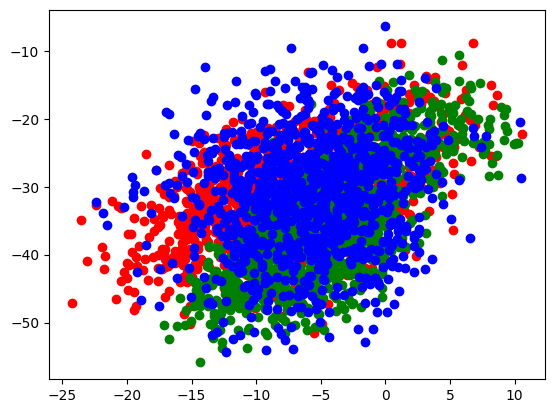

In [107]:
# MNIST latent space 시각화 : z 분포 w/ color
z = enc(whole_test_images)

z_0 = z[whole_test_labels==0]
z_1 = z[whole_test_labels==1]
z_2 = z[whole_test_labels==2]
z_3 = z[whole_test_labels==3]
z_4 = z[whole_test_labels==4]
z_5 = z[whole_test_labels==5]
z_6 = z[whole_test_labels==6]
z_7 = z[whole_test_labels==7]
z_8 = z[whole_test_labels==8]
z_9 = z[whole_test_labels==9]

plt.plot(z_0[:,0].detach().cpu().numpy(), z_0[:,1].detach().cpu().numpy(), 'ro')
plt.plot(z_1[:,0].detach().cpu().numpy(), z_1[:,1].detach().cpu().numpy(), 'go')
plt.plot(z_2[:,0].detach().cpu().numpy(), z_2[:,1].detach().cpu().numpy(), 'bo')

### n_dim = 2

In [108]:
n_dim = 2

enc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Linear(32,n_dim)
)

enc = enc.to(device)

# 디코더 정의
dec = nn.Sequential(
    nn.Linear(n_dim,32),
    nn.ReLU(),
    nn.Linear(32,256),
    nn.ReLU(),
    nn.Linear(256,784),
    nn.Unflatten(1, torch.Size([1,28,28])),
    nn.Sigmoid()
)

dec = dec.to(device)

# auto encoder 정의

ae = nn.Sequential(
    enc,
    dec,
)

ae = ae.to(device)


# ae 파라미터 초기화

def init_weights(m):
  for l in m.modules():
    if isinstance(l, nn.Linear):
      nn.init.xavier_uniform(l.weight)

ae.apply(init_weights)


# 오토인코더 학습

optimizer = torch.optim.Adam(ae.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

# 학습 fit() 함수 구현

def fit(data_loader, epochs):
  for epoch in range(epochs):
    now = time.time()
    avg_loss = 0
    total_batch = len(data_loader)

    for i, (batch_images, batch_labels) in enumerate(data_loader):

      X = batch_images.to(device)  # [-1, 1, 28, 28]

      # forward 단계
      Y_prediction = ae(X)
      loss = criterion(Y_prediction, X)


      # bacward 단계
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_loss += loss / total_batch

    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
          .format(epoch + 1, avg_loss.data, time.time()-now))

  print("Learning Finished!")

<ipython-input-108-ab88e395dc00>:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(l.weight)


In [109]:
fit(train_loader, num_epochs)

[Epoch:    1] 	 loss = 0.0588 	 time = 17.2401
[Epoch:    2] 	 loss = 0.0468 	 time = 18.9395
[Epoch:    3] 	 loss = 0.0433 	 time = 18.4092
[Epoch:    4] 	 loss = 0.0416 	 time = 19.1001
[Epoch:    5] 	 loss = 0.0404 	 time = 18.7384
[Epoch:    6] 	 loss = 0.0397 	 time = 19.2871
[Epoch:    7] 	 loss = 0.0391 	 time = 19.7443
[Epoch:    8] 	 loss = 0.0386 	 time = 20.3218
[Epoch:    9] 	 loss = 0.0383 	 time = 21.5932
[Epoch:   10] 	 loss = 0.0379 	 time = 22.6341
Learning Finished!


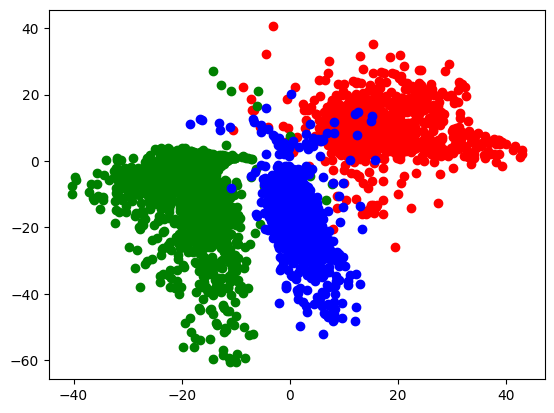

In [110]:
# MNIST latent space 시각화 : z 분포 w/ color
z = enc(whole_test_images)

z_0 = z[whole_test_labels==0]
z_1 = z[whole_test_labels==1]
z_2 = z[whole_test_labels==2]
z_3 = z[whole_test_labels==3]
z_4 = z[whole_test_labels==4]
z_5 = z[whole_test_labels==5]
z_6 = z[whole_test_labels==6]
z_7 = z[whole_test_labels==7]
z_8 = z[whole_test_labels==8]
z_9 = z[whole_test_labels==9]

plt.plot(z_0[:,0].detach().cpu().numpy(), z_0[:,1].detach().cpu().numpy(), 'ro')
plt.plot(z_1[:,0].detach().cpu().numpy(), z_1[:,1].detach().cpu().numpy(), 'go')
plt.plot(z_2[:,0].detach().cpu().numpy(), z_2[:,1].detach().cpu().numpy(), 'bo')

In [111]:
z

tensor([[-12.9920,   9.9353],
        [ -2.7750,  -8.4973],
        [-14.2441,  -8.2215],
        ...,
        [-12.9740,  15.3084],
        [ -7.3995,  23.9040],
        [ 24.9431, -26.3221]], grad_fn=<AddmmBackward0>)

## TODO 03 디코더를 이용한 생성형 모델(Generative Model)

In [150]:
# z 공간의 임의의 위치를 sampling, 랜덤으로 3개 추출
num_samples = 3
z = torch.randn(num_samples, n_dim).to(device)

# 랜덤으로 뽑힌 z를 decoder에 입력으로 주고, result에 저장
z = torch.FloatTensor(z).to(device)
result = dec(z)

print(z.shape)
print(result.shape)

torch.Size([3, 2])
torch.Size([3, 1, 28, 28])


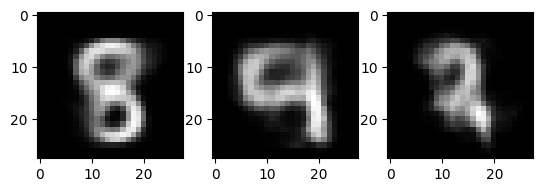

In [151]:
# 로딩된 MNIST 데이터 가시화
img1 = to_pil_image(result[0].squeeze())
img2 = to_pil_image(result[1].squeeze())
img3 = to_pil_image(result[2].squeeze())

plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')

plt.subplot(1,3,2)
plt.imshow(img2, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(img3, cmap='gray')

plt.show()

## TODO 04

In [ ]:
n_dim = 2

enc = nn.Sequential(
    nn.Conv2d(784, 256, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(256,128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(128,32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32,n_dim, kernel_size=3, stride=2, padding=1)
)

enc = enc.to(device)

# 디코더 정의
dec = nn.Sequential(
    nn.ConvTranspose2d(n_dim,32),
    nn.ReLU(),
    nn.ConvTranspose2d(32,256),
    nn.ReLU(),
    nn.ConvTranspose2d(256,784),
    nn.Unflatten(1, torch.Size([1,28,28])),
    nn.Sigmoid()
)

dec = dec.to(device)

# auto encoder 정의

ae = nn.Sequential(
    enc,
    dec,
)

ae = ae.to(device)

In [152]:
conv_enc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),)
conv_enc = conv_enc.to(device)


conv_dec = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 입력 이미지 채널: 32, 출력 이미지 채널: 16, 커널 사이즈: 3x3
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 입력 이미지 채널: 16, 출력 이미지 채널: 1, 커널 사이즈: 3x3
            nn.Sigmoid(),
)
conv_dec = conv_dec.to(device)

conv_ae = nn.Sequential(
    conv_enc,
    conv_dec,
)


In [153]:
# 오토인코더 학습

optimizer = torch.optim.Adam(conv_ae.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

# 학습 fit() 함수 구현

def fit(data_loader, epochs):
  for epoch in range(epochs):
    now = time.time()
    avg_loss = 0
    total_batch = len(data_loader)

    for i, (batch_images, batch_labels) in enumerate(data_loader):

      X = batch_images.to(device)  # [-1, 1, 28, 28]

      # forward 단계
      Y_prediction = conv_ae(X)
      loss = criterion(Y_prediction, X)


      # bacward 단계
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_loss += loss / total_batch

    print("[Epoch: {:>4}] \t loss = {:.4f} \t time = {:.4f}"
          .format(epoch + 1, avg_loss.data, time.time()-now))

  print("Learning Finished!")

In [154]:
fit(train_loader, num_epochs)

[Epoch:    1] 	 loss = 0.0230 	 time = 29.6432
[Epoch:    2] 	 loss = 0.0013 	 time = 30.7268
[Epoch:    3] 	 loss = 0.0009 	 time = 26.6860
[Epoch:    4] 	 loss = 0.0007 	 time = 27.7922
[Epoch:    5] 	 loss = 0.0006 	 time = 26.7564
[Epoch:    6] 	 loss = 0.0006 	 time = 27.0712
[Epoch:    7] 	 loss = 0.0005 	 time = 27.6378
[Epoch:    8] 	 loss = 0.0005 	 time = 27.3524
[Epoch:    9] 	 loss = 0.0004 	 time = 26.1260
[Epoch:   10] 	 loss = 0.0004 	 time = 29.8119
Learning Finished!


In [155]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import ipywidgets as widgets

def test_dataset_imshow(idx):
  (image, label) = test_dataset[idx]
  print('GT label:', label)

  X      = torch.unsqueeze(image, 0).to(device) # batch size = 1
  Y_pred = conv_ae(X)

  input_img  = to_pil_image(X.squeeze())
  output_img = to_pil_image(Y_pred.squeeze())

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')

  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')

  plt.show()

widgets.interact(test_dataset_imshow, idx=widgets.IntSlider(min=0, max=len(test_dataset)-1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

<function __main__.test_dataset_imshow(idx)>